In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
from scipy.stats import linregress
from tqdm.notebook import tqdm
from os import listdir
from os.path import isfile, join, isdir
from IPython.display import display, HTML
from lmfit import Model, Parameters
from datetime import timedelta

In [2]:
# Data path
daily_path = "COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"

# Useless columns in data
to_del = ['Latitude', 'Lat', 'Lat_', 'Longitude', 'Long', 'Long_',
          'FIPS', 'Province_State', 'Combined_Key', 'Active']

tt_inf = 1580515200

# Columns value in data
categories = ['Confirmed', 'Deaths']
# Colors for Confirmed, Deaths, Recovered
colors = ['red', 'black', 'green']
# Make prediction until this date
report_date = '7/1/2020'

# Different names for Date column in data
lu_names = ['Last Update', 'Last_Update']
DATE = 'Date'
# Different names for Country column in data
cr_names = ['Country/Region', 'Country_Region']
COUNTRY = 'Country'

# Different names for some countries in data
sim_countries = {'Azerbaijan': [' Azerbaijan'], 'Bahamas': ['Bahamas, The', 'The Bahamas'],
                 'Cape Verde': ['Cabo Verde'], 'Congo (Brazzaville)': ['Republic of the Congo'],
                 'Czechia': ['Czech Republic'], 'Gambia': ['Gambia, The', 'The Gambia'],
                 'Hong Kong': ['Hong Kong SAR'], 'Iran': ['Iran (Islamic Republic of)'],
                 'Ireland': ['Republic of Ireland'], 'Macao': ['Macau', 'Macao SAR'],
                 'Moldova': ['Republic of Moldova'], 'Russia': ['Russian Federation'],
                 'South Korea': ['Korea, South', 'Republic of Korea'], 'Taiwan': ['Taiwan*'],
                 'UK': ['United Kingdom'], 'Vietnam': ['Viet Nam'], 'West Bank and Gaza': ['occupied Palestinian territory']}

In [3]:
# Get the data on GitHub
if isdir(daily_path):
    %cd COVID-19/
    !git pull
    %cd ..
else:
    !git clone https://github.com/CSSEGISandData/COVID-19

/home/anthony/Documents/Programs/covid19/COVID-19
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 14 (delta 6), reused 11 (delta 6), pack-reused 0
Unpacking objects: 100% (14/14), done.
From https://github.com/CSSEGISandData/COVID-19
   d204381e..8d730f09  web-data   -> origin/web-data
Already up to date.
/home/anthony/Documents/Programs/covid19


In [4]:
# List the csv files in specific location
def list_csv_files(path):
    return [f for f in listdir(path) if isfile(join(path, f)) and f[-4:] == '.csv']

# Rename some candidate columns in dataframe
def rename_column(df, names, right_one):
    for n in names:
        if n in df.columns:
            return df.rename(columns={n:right_one})
    return df

# List all the data files
daily_files = list_csv_files(daily_path)
to_prec = [pd.read_csv(daily_path+f, parse_dates=True) for f in daily_files]

daily_df = []
for df in to_prec:
    # Renaming of columns
    df = rename_column(df, lu_names, DATE)
    df[DATE] = pd.to_datetime(df[DATE])
    df = rename_column(df, cr_names, COUNTRY)
    
    # Replace country names for data consistency
    for c in sim_countries:
        for v in sim_countries[c]:
            df = df.replace(v, c)
    
    # Reduction to a state scale
    date = df[DATE][0]
    df = df.groupby(COUNTRY, as_index=False).sum()
    df[DATE] = [date]*len(df)
    
    # Deletion of useless columns
    for d in to_del:
        if d in df.columns:
            df = df.drop(d, axis=1)
            
    daily_df.append(df)

# Merge and sort by country and date
df = pd.concat(daily_df).sort_values([COUNTRY, DATE]).reindex()
df

,Country,Confirmed,Deaths,Recovered,Date
0,Afghanistan,1.0,0.0,0.0,2020-02-24 11:13:09
0,Afghanistan,1.0,0.0,0.0,2020-02-25 15:23:04
0,Afghanistan,1.0,0.0,0.0,2020-02-26 14:13:10
0,Afghanistan,1.0,0.0,0.0,2020-02-27 12:13:14
0,Afghanistan,1.0,0.0,0.0,2020-02-28 00:43:01
...,...,...,...,...,...
172,Zimbabwe,3.0,1.0,0.0,2020-03-25 23:33:19
174,Zimbabwe,3.0,1.0,0.0,2020-03-26 23:48:35
175,Zimbabwe,5.0,1.0,0.0,2020-03-27 22:14:55
176,Zimbabwe,7.0,1.0,0.0,2020-03-28 23:05:37


In [5]:
# Load continents data
continents = pd.read_csv('./continents.csv', index_col='Country')

# Split df by country
tmp_df_country = []
countries = df[COUNTRY].unique()
for c in countries:
    dfc = df.loc[df[COUNTRY] == c, :]
    # Add the continent data
    dfc.loc[:, 'Continent'] = continents.loc[c, 'Continent']
    tmp_df_country.append(dfc)
    
# Adjust inconsistent data in country dataframes
df_country = []
for dfc in tmp_df_country:
    if dfc.shape[0] >= 4:
        dfc = dfc.reset_index()
        for c in categories:
            last = None
            for i in dfc.index:
                if last is not None and dfc.loc[last][c] > dfc.loc[i][c]:
                    dfc.loc[i, c] = dfc.loc[last, c]
                last = i
        df_country.append(dfc)

/home/anthony/.local/lib/python3.6/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/anthony/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
# Define a gaussian curve
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Define a linear
def lin(x,a,b):
    return a*x + b

# Turn dates into number to allow the regression
def turn_dates_to_number(dates):
    return (pd.to_datetime(dates).astype(int) / 10**9 - tt_inf) / (7*86400)

# Turn a single date to a number to allow the regression
def turn_date_to_number(date):
    return (date.timestamp() - tt_inf) / (7*86400)

def number_to_date(nb):
    return pd.Timestamp(7*86400*nb + tt_inf, unit='s')

def number_to_delta(nb):
    return pd.Timedelta(seconds=7*86400*nb)

# Gaussian regression to data, linear if the gaussian one fails
def get_best_fit(dfc, c):
    x = turn_dates_to_number(dfc[DATE])
    y = dfc[c]
    
    # Estimations to help the regression
    y_sum = sum(y)
    if y_sum == 0:
        return [0, 0, 1]
    
    est_amp = y.max()
    est_mean = sum(x*y) / y_sum
    est_std = sum(y*abs(x - est_mean)) / y_sum
    if est_std == 0:
        est_std = 1
    
    gmodel = Model(gaus)
    fit_params = Parameters()
    fit_params.add('a', value=est_amp, max=7*y.max(), min=1)
    fit_params.add('x0', value=est_mean, min=0)
    fit_params.add('sigma', value=est_std, min=0.001, max=20)
    # Gaussian regression
    try:
        result = gmodel.fit(y, fit_params, x=x)
        bv = result.best_values
        parameters = [bv['a'], bv['x0'], bv['sigma']]
    except RuntimeError:
        # Linear regression
        print(dfc[COUNTRY].iloc[0], c, 'Fail')
        a,b,_,_,_ = linregress(x, y)
        parameters = [a, b]
    
    return parameters

# Apply func(row, params)
def estimate(func, row, params):
    x = turn_date_to_number(row[DATE])
    return func(x, *params)

In [7]:
# Computing the variability in the data
for dfc in df_country:
    for cat in categories:
        dfc.loc[:, 'Diff-'+cat] = dfc[cat].diff()
        
# Modelisation by country/category
modelled_countries = []
for dfc in tqdm(df_country, desc="Modelling countries..."):
    for c in categories:
        params_c = get_best_fit(dfc.dropna(), 'Diff-'+c)
        dfc['Params-Diff-'+c] = [tuple(params_c)] * len(dfc)
        f = gaus if len(params_c) == 3 else lin
        dfc['Est-Diff-'+c] = dfc.apply(lambda row: estimate(f, row, params_c), axis=1)

    modelled_countries.append(dfc)

In [8]:
# Retrieve a value at a specific date in a dataframe
def get_value_at_date(dfc, c, date):
    d = date.replace(hour=0, minute=0, second=0, microsecond=0, nanosecond=0)
    if d in dfc.index:
        return round(dfc.loc[d, c])
    
    return None

# Make predictions over a given period
def predict_over_period(date_start, date_end, params=None):
    # Range of date
    x_date= pd.date_range(start=date_start, end=date_end)
    n = len(x_date)
    
    if params is not None:
        # Obtain predictions
        x_nb = turn_dates_to_number(x_date)
        f = gaus if len(params) == 3 else lin
        y_diff = pd.to_numeric(f(x_nb, *params))

        # Deduce the sigmoid from the gaussian with a cumulative sum
        y_cum = 0
        y_real = []
        for y in y_diff:
            y_cum += y
            y_real.append(y_cum)
    else:
        y_diff = [None]*n
        y_real = [None]*n
    
    # Return x, the sigmoid and the gaussian
    return x_date, y_real, y_diff

# Extend a given dataframe with the predictions
def extend_with_predictions(dfc, date_until=report_date):
    start_date = dfc[DATE].min().replace(hour=0, minute=0, second=0, microsecond=0, nanosecond=0)
    df_dict = {c:[] for c in list(dfc.columns.drop('index'))+['Est-'+cr for cr in categories]}
    for c in categories:
        x_date, y_real, y_diff = predict_over_period(start_date, date_until, dfc['Params-Diff-'+c].iloc[0])
        df_dict[DATE] = list(x_date)
        df_dict['Est-Diff-'+c] = list(y_diff)
        df_dict['Est-'+c] = list(y_real)
        
    # Extension of original data with Nones
    n = len(df_dict[DATE])
    for c in ['Recovered', 'Deaths', 'Confirmed']:
        df_dict[c] = list(dfc[c])
        nt = len(df_dict[c])
        for i in range(n-nt):
            df_dict[c].append(None)
          
    # Extension of constant columns
    df_dict[COUNTRY] = [dfc[COUNTRY].iloc[0]] * n
    df_dict['Continent'] = [dfc['Continent'].iloc[0]] * n
    for c in categories:
        df_dict['Diff-'+c] = list(dfc['Diff-'+c])
        nt = len(df_dict['Diff-'+c])
        for i in range(n-nt):
            df_dict['Diff-'+c].append(None)
        df_dict['Params-Diff-'+c] = [dfc['Params-Diff-'+c].iloc[0]] * n
        
    return pd.DataFrame.from_dict(df_dict).set_index(DATE)
    
# Extend all the country dataframes with predictions
for i,dfc in enumerate(modelled_countries):
    modelled_countries[i] = extend_with_predictions(dfc)

In [9]:
# Retrieve the country dataframe
def get_country_df(country):
    for dfc in modelled_countries:
        if dfc[COUNTRY].iloc[0] == country:
            return dfc
    
    return None

# Retrieve the country dataframes belonging to a continent
def get_continent_collection(continent):
    collection = []
    for dfc in modelled_countries:
        if dfc['Continent'].iloc[0] == continent:
            collection.append(dfc)
    return collection

# Report with collection of country dataframes
def get_collection_df(collection, date_end=report_date):
    df_dict = {c:[] for c in list(collection[0].columns) if 'Params' not in c and COUNTRY not in c and 'Continent' not in c}

    # Get interval of dates
    date_start = None
    for dfc in collection:
        challenger = dfc.index.min()
        if date_start is None or challenger < date_start:
            date_start = challenger
    df_dict[DATE] = list(pd.date_range(start=date_start, end=date_end))
    
    # Aggregate over the collection
    left = [c for c in ['Recovered', 'Deaths', 'Confirmed'] if c not in categories]
    cats = categories + ['Diff-'+c for c in categories]
    cats += ['Est-'+c for c in cats] + left
    for date in df_dict[DATE]:
        for c in cats:
            none = True
            df_dict[c].append(0)
            for dfc in collection:
                v = get_value_at_date(dfc, c, date)
                if v is not None and not math.isnan(v):
                    none = False
                    df_dict[c][-1] += v
            if none:
                df_dict[c][-1] = None
    
    return pd.DataFrame.from_dict(df_dict).set_index(DATE)

In [10]:
def country_prediction_evolution(dfc, c, start_date=None, end_date=None):
    if start_date is None:
        start_date = dfc[c].dropna().index.min()
    if end_date is None:
        end_date = dfc[c].dropna().index.max()
    
    dates = pd.date_range(start_date, end_date)
    amps = []
    means = []
    stds = []
    for i,d in enumerate(dates):
        if i >= 3:
            sub_dfc = dfc.loc[:d].dropna()
            sub_dfc[DATE] = sub_dfc.index
            params = get_best_fit(sub_dfc, 'Diff-'+c)
            amps.append(params[0])
            means.append(params[1])
            stds.append(params[2])
        else:
            amps.append(None)
            means.append(None)
            stds.append(None)
    
    return dates, amps, means, stds

def show_parameters_graph(d, a, m, s, c, cat):                
    p_names = ['Amplitude', 'Mean', 'Stand Dev']
    lines = [a, m, s]
    fig, axes = plt.subplots(1, 3, figsize=(20,5))
    for i,v in enumerate(lines):
        axes[i].set_title(c + ' - ' + cat + ' - ' + p_names[i])
        axes[i].plot(d, v)
    plt.show()
    
def parameter_roll_mean_std(p_list, period=7):
    s = pd.Series(p_list).rolling(period)
    return s.mean(), s.std()

In [11]:
# Show graphs of categories
def show_graphs(dfc, c):
    x = dfc.index
    xnb = turn_dates_to_number(x)
    
    # True data
    fig, axes = plt.subplots(1, len(categories), figsize=(20,5))
    for i,cat in enumerate(categories):
        axes[i].set_title(c + ' - ' + cat)
        axes[i].plot(x, dfc[cat], c=colors[i], linewidth=2)
        axes[i].plot(x, dfc['Est-'+cat], c=colors[i], linewidth=1)

    plt.show()
    
    # Diff
    fig, axes = plt.subplots(1, len(categories), figsize=(20,5))
    for i,cat in enumerate(categories):
        axes[i].set_title(c + ' - New ' + cat + ' per day')
        axes[i].fill_between(x, dfc['Diff-'+cat], 0, facecolor=colors[i], alpha=1)
        axes[i].fill_between(x, dfc['Est-Diff-'+cat], 0, facecolor=colors[i], linewidth=1, alpha=0.3)
            
    plt.show()
    
# Return statistics on the inflection
def get_inflection_stats(dfc, c):
    idx = dfc['Est-Diff-'+c].argmax()
    idx = pd.Timestamp(dfc.index.values[idx])
    return idx.replace(hour=0, minute=0), round(dfc.loc[idx, 'Est-Diff-'+c])

# Return statistics overall
def get_overall_prediction(dfc):
    lr = dfc.iloc[-1]
    last_date = pd.Timestamp(dfc.index.values[-1])
    i = 2
    while round(dfc.iloc[-i]['Est-Diff-Confirmed']) == 0:
        last_date = pd.Timestamp(dfc.index.values[-i])
        i += 1
        
    return round(lr['Est-Confirmed']), round(lr['Est-Deaths']), last_date.replace(hour=0, minute=0)

# Return predictions for today
def get_day_prediction(dfc):
    now = pd.Timestamp.now()
    
    return get_value_at_date(dfc, 'Est-Confirmed', now), get_value_at_date(dfc, 'Est-Deaths', now), \
           get_value_at_date(dfc, 'Est-Diff-Confirmed', now), get_value_at_date(dfc, 'Est-Diff-Deaths', now)
    
# Gather statistics in a dataframe
def get_statistics(dfc):
    low_dr = round(100*dfc['Deaths'].dropna().iloc[-1] / dfc['Confirmed'].dropna().iloc[-1], 2)
    up_dr = round(100*dfc['Deaths'].dropna().iloc[-1] / (dfc['Deaths'].dropna().iloc[-1] + dfc['Recovered'].dropna().iloc[-1]), 2)
    est_dr = round(100*dfc['Est-Deaths'].iloc[-1] / dfc['Est-Confirmed'].iloc[-1], 2)
    
    conf, deaths, diff_conf, diff_deaths = get_day_prediction(dfc)
    
    inf_conf_date, inf_conf_val = get_inflection_stats(dfc, 'Confirmed')
    inf_death_date, inf_death_val = get_inflection_stats(dfc, 'Deaths')
    
    est_conf, est_deaths, end = get_overall_prediction(dfc)
    
    mca, mcs, mda, mds, aca, acs, ada, ads = None, None, None, None, None, None, None, None
    if COUNTRY in dfc.columns:
        _, ac, mc, _ = country_prediction_evolution(dfc, 'Confirmed')
        _, ad, md, _ = country_prediction_evolution(dfc, 'Deaths')
        aca, acs = parameter_roll_mean_std(ac)
        mca, mcs = parameter_roll_mean_std(mc)
        ada, ads = parameter_roll_mean_std(ad)
        mda, mds = parameter_roll_mean_std(md)
        
        aca, acs, ada, ads = round(aca.iloc[-1]), round(acs.iloc[-1]), round(ada.iloc[-1]), round(ads.iloc[-1])
        mca, mcs = number_to_date(mca.iloc[-1]).round('d'), number_to_delta(mcs.iloc[-1]).round('d')
        mda, mds = number_to_date(mda.iloc[-1]).round('d'), number_to_delta(mds.iloc[-1]).round('d')
        
    
    col_name = "Statistic"
    col_av = 'Avg'
    col_std = 'Std'
    stats = {"NOW": {"Low DR": {col_name: low_dr, col_av: None, col_std: None},
                     "Up DR": {col_name: up_dr, col_av: None, col_std: None},
                     "Confirmed": {col_name: conf, col_av: None, col_std: None},
                     "Deaths": {col_name: deaths, col_av: None, col_std: None},
                     "New Confirmed": {col_name: diff_conf, col_av: None, col_std: None},
                     "New Deaths": {col_name: diff_deaths, col_av: None, col_std: None}},
             "INFLECTION": {"Date Confirmed": {col_name: inf_conf_date.round('d'), col_av: mca, col_std: mcs},
                            "Peak Confirmed": {col_name: inf_conf_val, col_av: aca, col_std: acs},
                            "Date Deaths": {col_name: inf_death_date.round('d'), col_av: mda, col_std: mds},
                            "Peak Deaths": {col_name: inf_death_val, col_av: None, col_std: None}},
            "OVERALL": {"DR": {col_name: est_dr, col_av: None, col_std: None},
                        "Last infected": {col_name: end, col_av: None, col_std: None},
                        "Confirmed": {col_name: est_conf, col_av: None, col_std: None},
                        "Deaths": {col_name: est_deaths, col_av: None, col_std: None}}}
    
    return pd.DataFrame.from_dict({(i,j): stats[i][j] 
                           for i in stats.keys() 
                           for j in stats[i].keys()},
                       orient='index')

In [12]:
# Print a report (graphs + statistics) for a provided dataframe
def df_report(df, label):
    show_graphs(df, label)
    display(HTML(get_statistics(df).to_html()))

# Print a report for a country
def country_report(c):
    dfc = get_country_df(c)   
    df_report(dfc, dfc[COUNTRY].iloc[0])

# Report for a provided continent
def continent_report(continent):
    col = get_continent_collection(continent)
    dfe = get_collection_df(col)
    df_report(dfe, continent)

# Report for the whole world
def world_report():
    dfw = get_collection_df(modelled_countries)
    df_report(dfw, 'World')

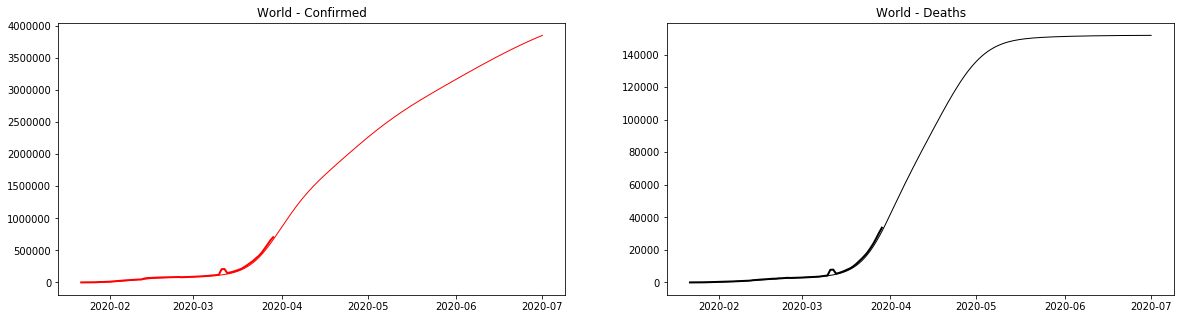

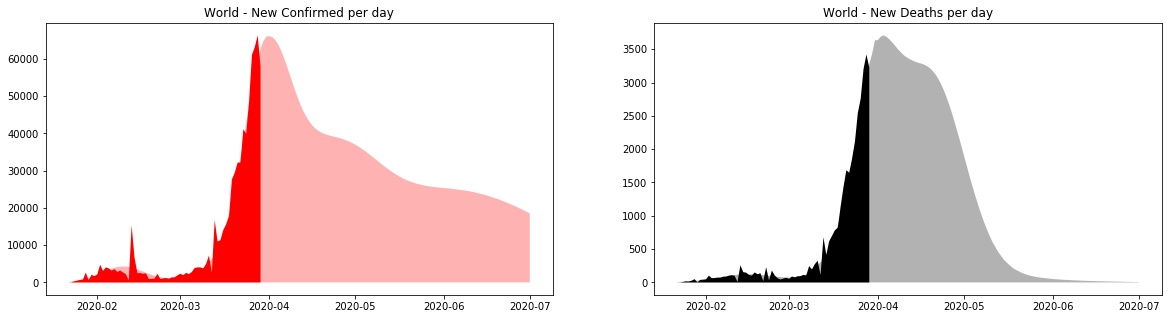

In [13]:
world_report()

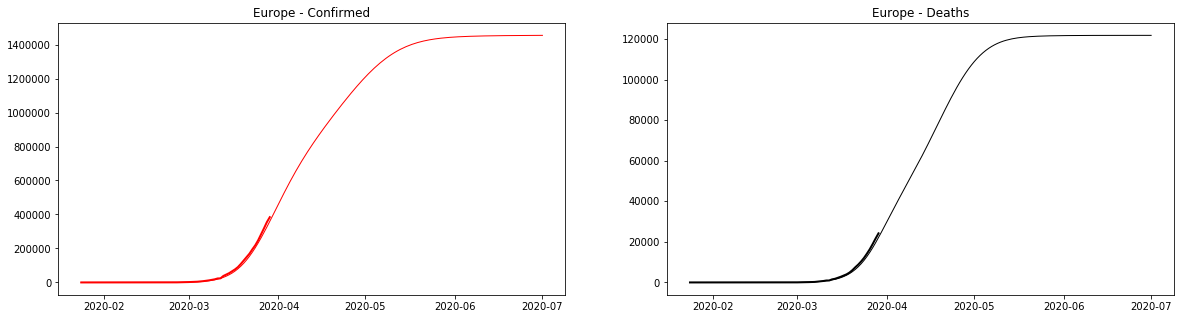

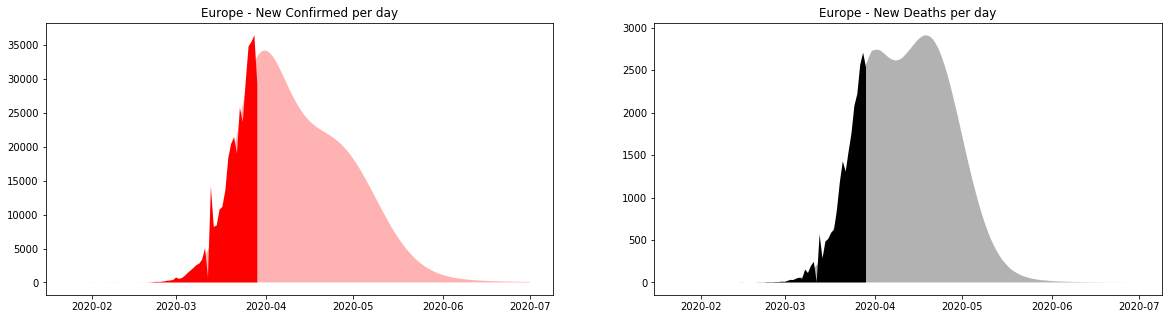

In [14]:
continent_report('Europe')

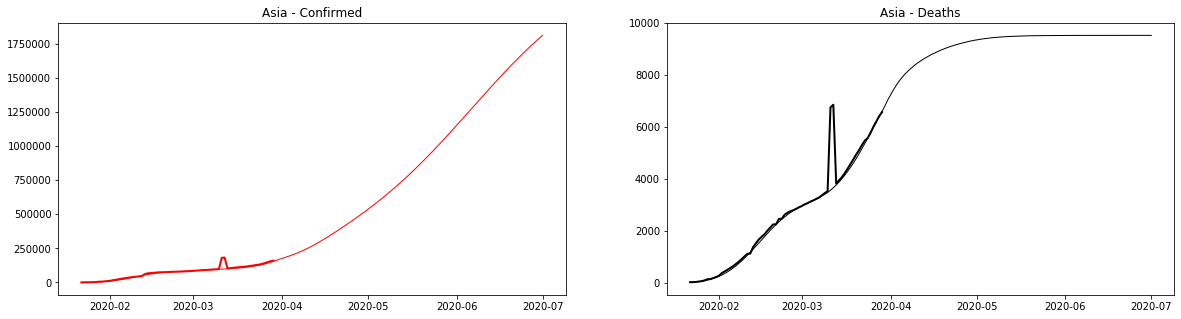

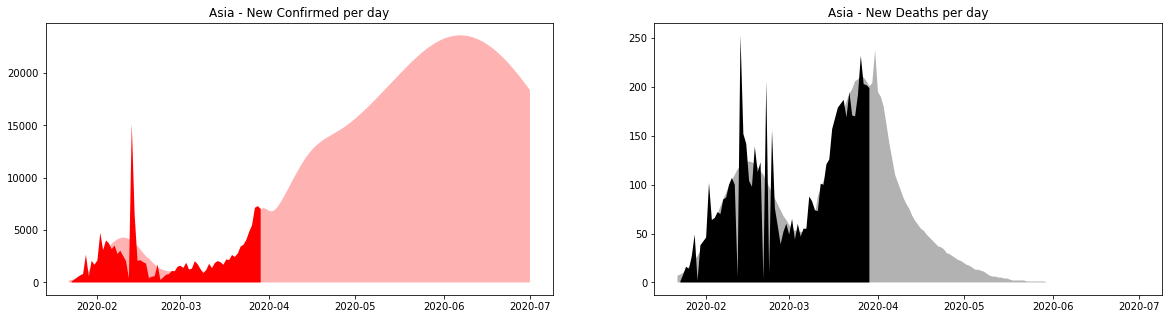

In [15]:
continent_report('Asia')

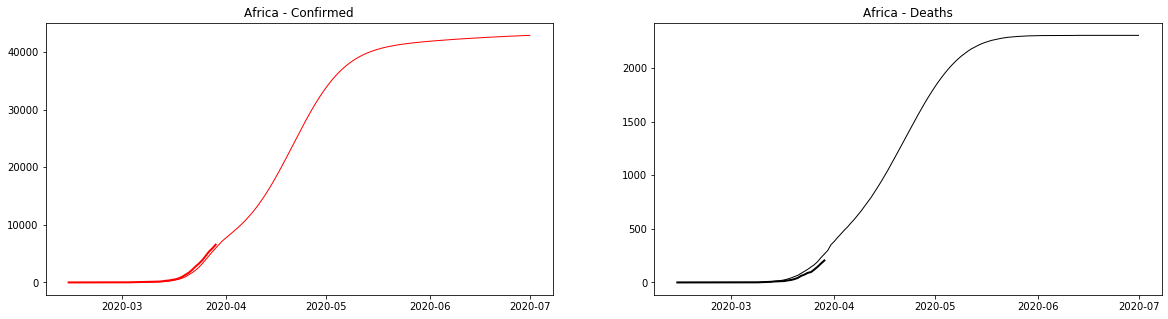

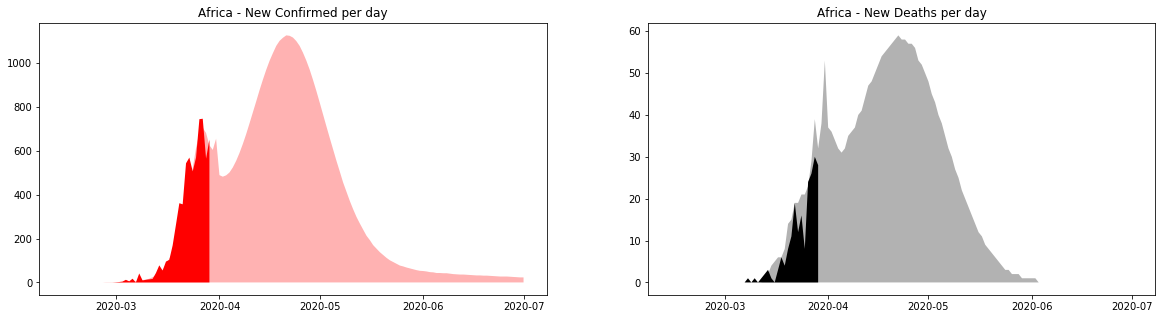

In [16]:
continent_report('Africa')

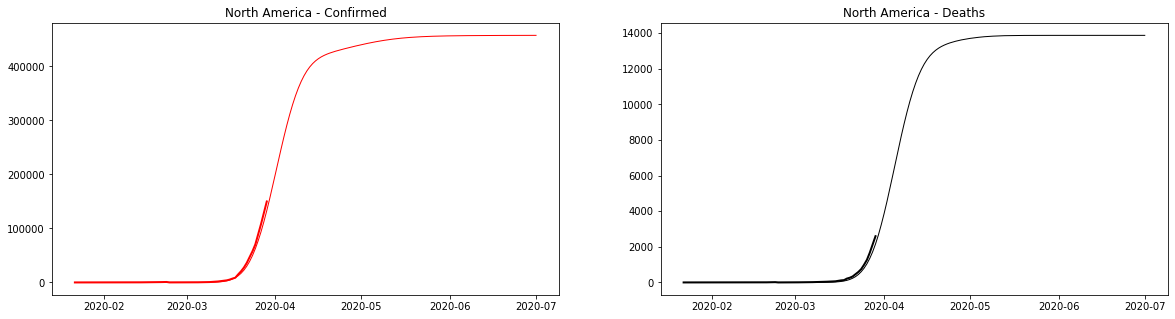

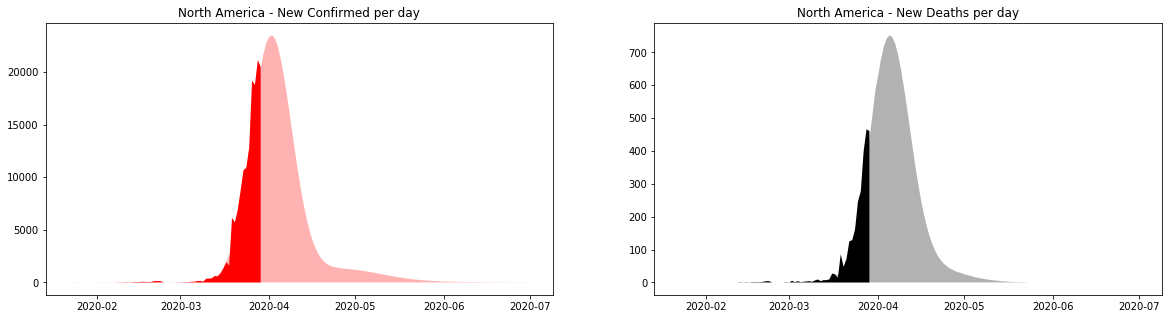

In [17]:
continent_report('North America')

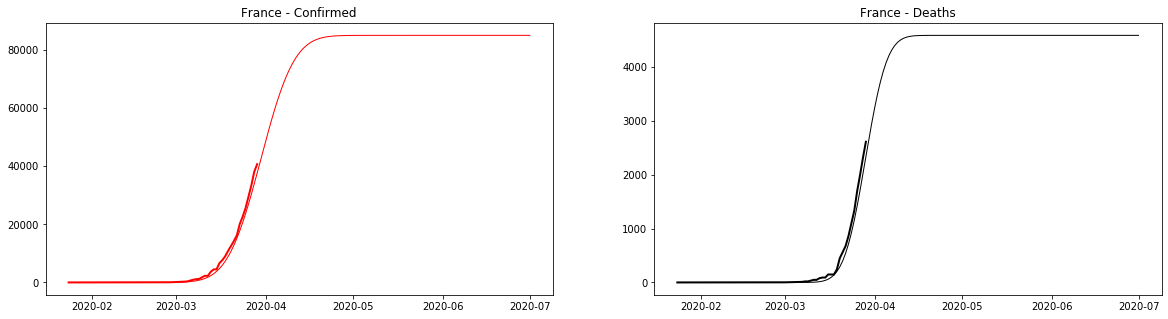

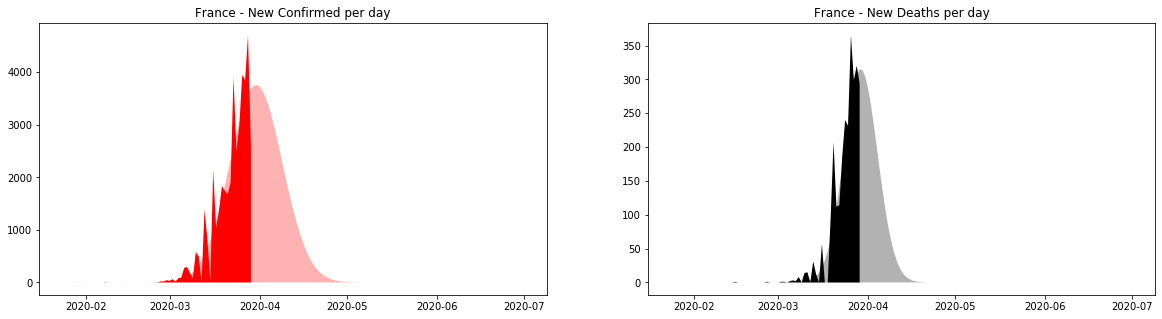

In [18]:
country_report('France')

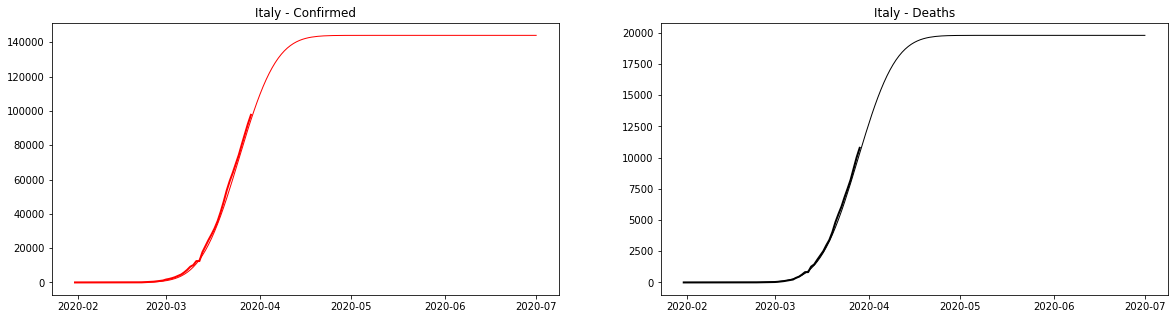

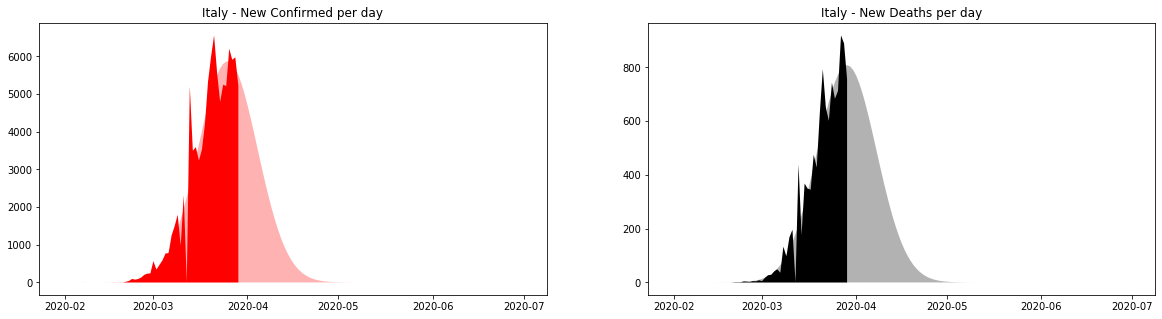

In [19]:
country_report('Italy')

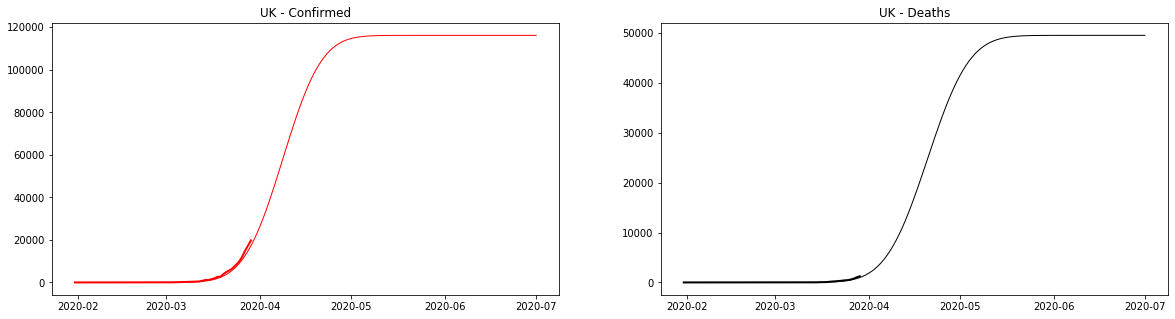

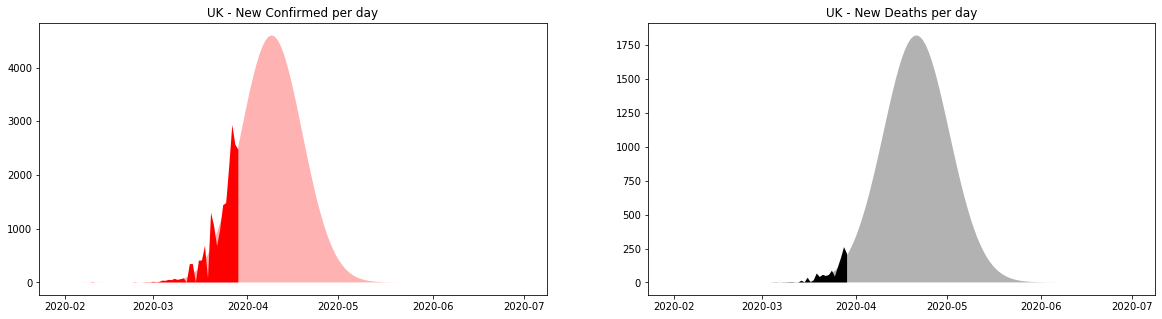

In [20]:
country_report('UK')

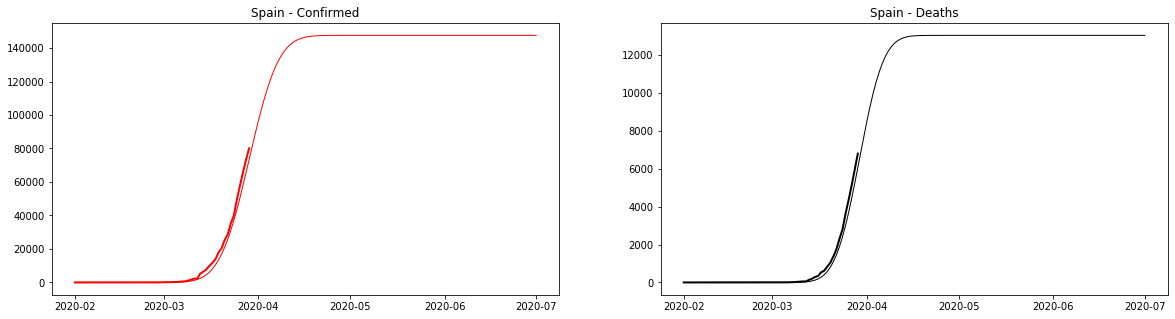

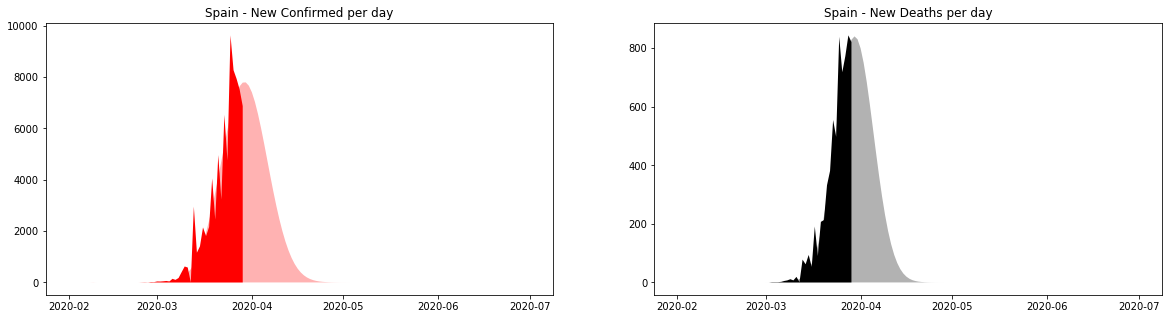

In [21]:
country_report('Spain')

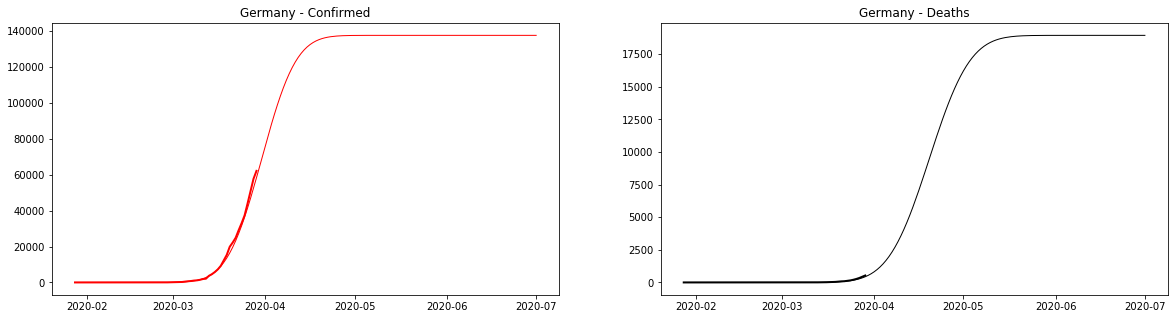

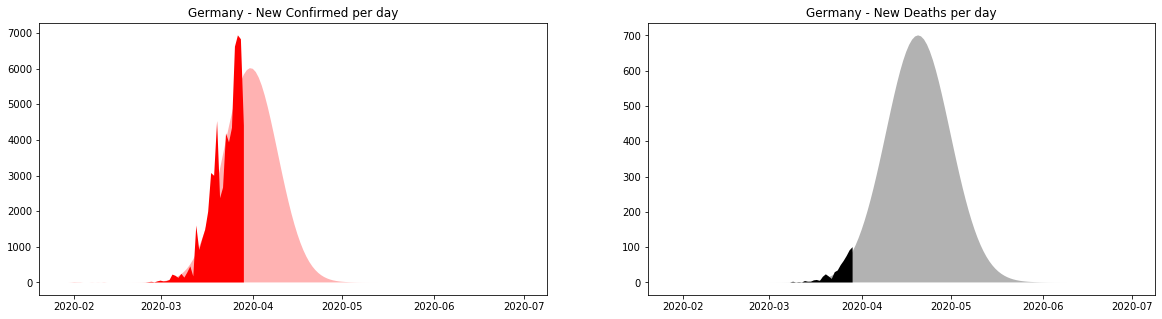

In [22]:
country_report('Germany')

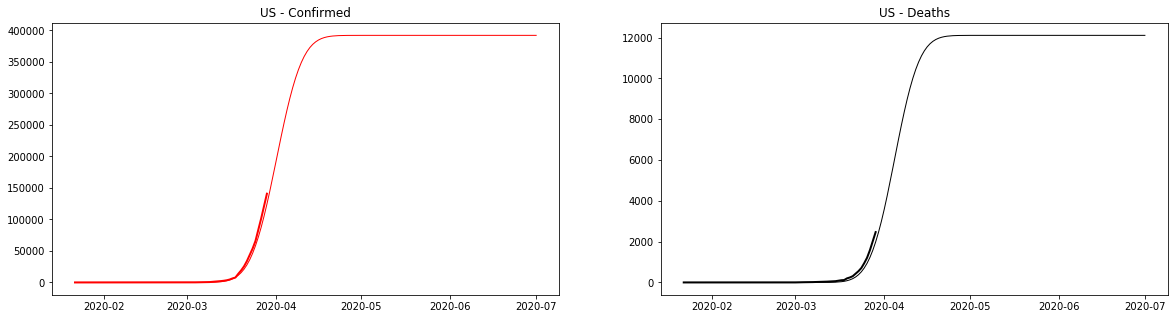

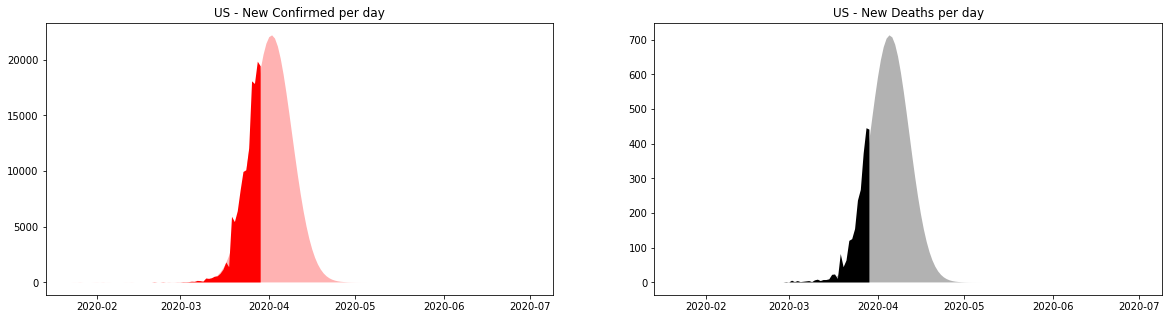

In [23]:
country_report('US')

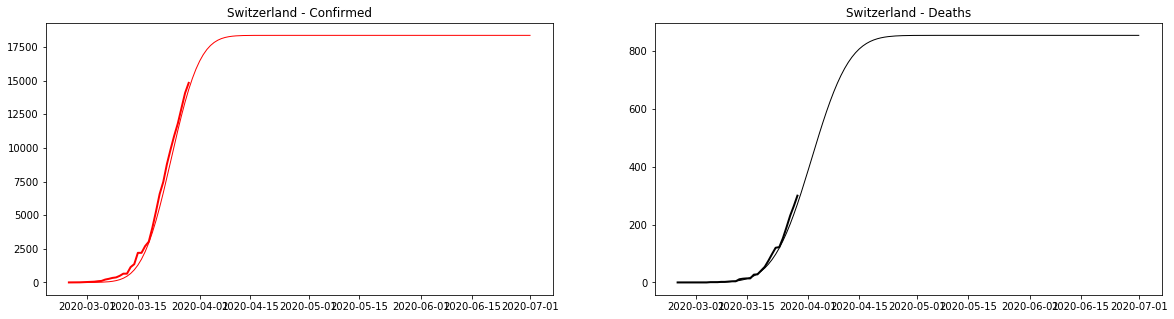

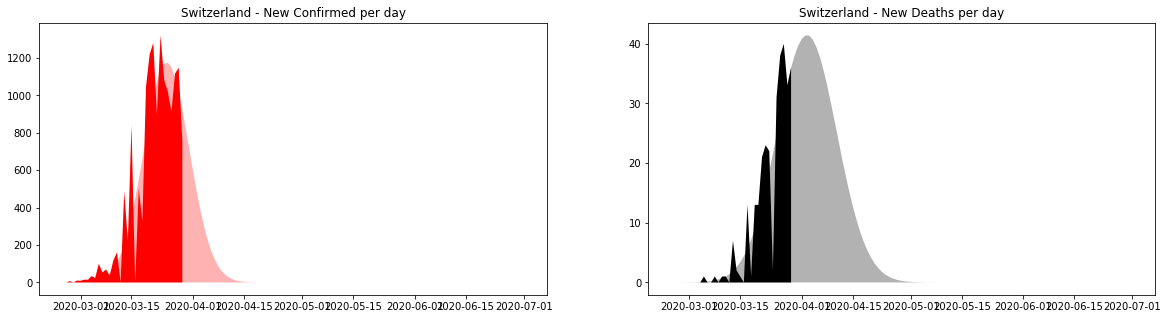

In [24]:
country_report('Switzerland')

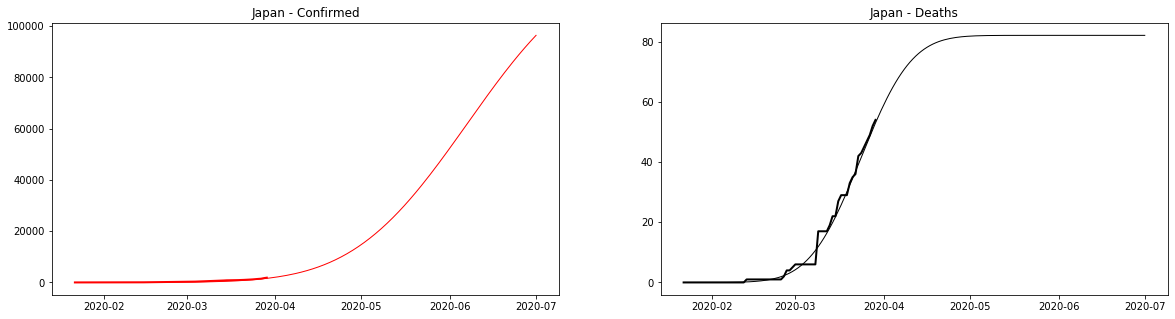

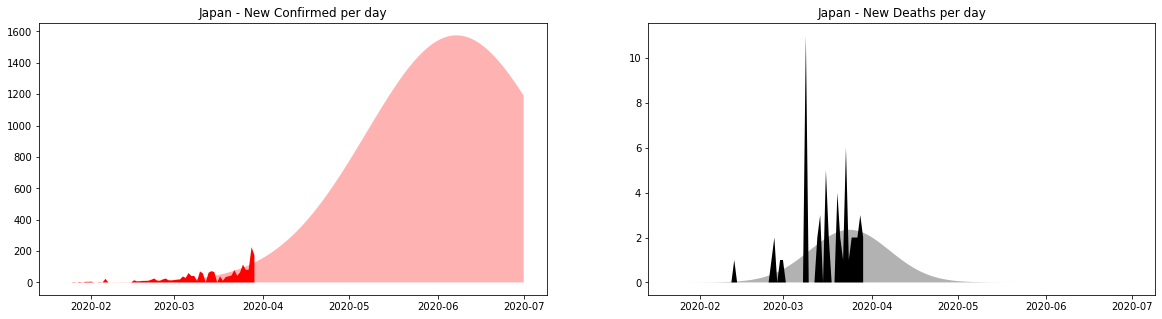

In [25]:
country_report('Japan')